In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.mixed_method_0.mixed_method_0_operators import charge_density_two_stream_mixed_method_0
from operators.legendre.legendre_operators import xi_legendre
from operators.aw_hermite.aw_hermite_operators import aw_psi_hermite, aw_psi_hermite_complement
from operators.mixed_method_1.setup_mixed_method_1_two_stream import SimulationSetupMixedMethod1
from operators.poisson_solver import gmres_solver
from operators.aw_hermite.aw_hermite_operators import total_mass_aw_hermite, total_momentum_aw_hermite, total_energy_k_aw_hermite
from operators.legendre.legendre_operators import total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
from matplotlib import colors
import matplotlib
font = {'family' : 'serif',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

In [4]:
import matplotlib.cm as cm

# Get the 'inferno' colormap
inferno_cmap = cm.get_cmap('inferno')

# Sample the colormap at three different points (e.g., 25%, 50%, 75%)
color1 = inferno_cmap(0.)
color2 = inferno_cmap(0.2)
color3 = inferno_cmap(0.5)
color4 = inferno_cmap(0.75)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_3620/2241193680.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno_cmap = cm.get_cmap('inferno')


In [5]:
v_a = 2
v_b = 3
alpha = np.sqrt(2)
u =0 

In [6]:
v_ = np.linspace(-6, 6, 601, endpoint=True)
v_legendre = np.linspace(v_a, v_b, 601, endpoint=True)
x_ = np.linspace(0, 2*np.pi, 100)
t_ = np.linspace(0, 5, 5)

In [7]:
psi0 = aw_psi_hermite(v=v_, alpha_s=alpha, u_s=u, n=0)

In [8]:
xi2 = np.zeros(len(v_))
xi0 = np.zeros(len(v_))
for ii, v in enumerate(v_):
    if v >= v_a and v <= v_b:
        xi2[ii] = xi_legendre(v=v, v_a=v_a, v_b=v_b, n=2)
        xi0[ii] = xi_legendre(v=v, v_a=v_a, v_b=v_b, n=0)

In [9]:
g = 0.1*np.sqrt(5)*xi0-0.1*xi2+psi0

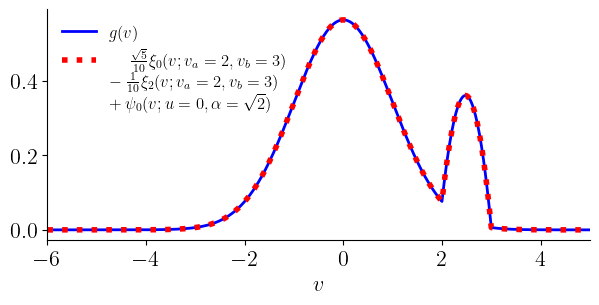

In [10]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.plot(v_, 0.1*np.sqrt(5)*xi0-0.1*xi2+psi0, label=r"$g(v)$", linewidth=2, color="blue")
ax.plot(v_, g, label=r"$\frac{\sqrt{5}}{10} \xi_{0}(v; v_{a} = 2, v_{b}=3) \\- \frac{1}{10}\xi_{2}(v; v_{a} = 2, v_{b} = 3) \\+ \psi_{0}(v; u=0, \alpha=\sqrt{2})$", linewidth=4, ls=":", color="red")

ax.set_xlim(-6, 5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$v$")

legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper left')
legend.get_frame().set_alpha(0)

# get hermite approximation 

In [11]:
Nv = 40
C = np.zeros(Nv) 

for ii in range(Nv):
    C[ii] = scipy.integrate.trapezoid(g*aw_psi_hermite_complement(n=ii, alpha_s=alpha, u_s=u, v=v_), x=v_, dx=np.abs(v_[1] - v_[0])) /alpha

In [12]:
sol_full_10 = np.zeros(len(v_))
sol_full_20 = np.zeros(len(v_))
sol_full_40 = np.zeros(len(v_))

for nn in range(10):
    sol_full_10 += C[nn] * aw_psi_hermite(n=nn, alpha_s=alpha, u_s=u, v=v_)
for nn in range(20):
    sol_full_20 += C[nn] * aw_psi_hermite(n=nn, alpha_s=alpha, u_s=u, v=v_)
for nn in range(40):
    sol_full_40 += C[nn] * aw_psi_hermite(n=nn, alpha_s=alpha, u_s=u, v=v_)

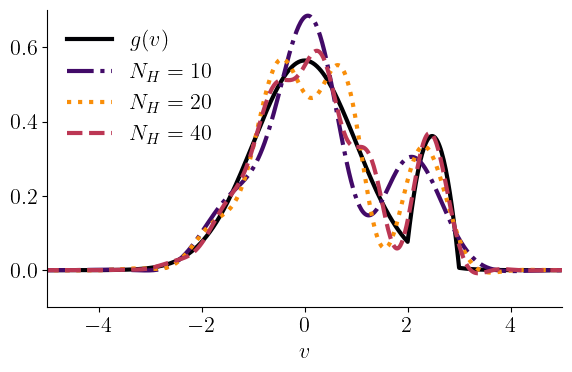

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(v_, g, label=r"$g(v)$", color=color1, linewidth=3)
ax.plot(v_, sol_full_10, color=color2, ls="-.", label=r"$N_{H} = 10$", linewidth=3)
ax.plot(v_, sol_full_20, color=color4, ls=":", label=r"$N_{H} = 20$", linewidth=3)
ax.plot(v_, sol_full_40, color=color3, ls="--", label=r"$N_{H} = 40$", linewidth=3)


legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=16, loc='upper left')
legend.get_frame().set_alpha(0)
ax.set_xlim(-5, 5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$v$")
ax.set_ylim(-0.1, 0.7)
plt.tight_layout()
plt.savefig("../../figures/functional_analysis/hermite_approx.png", dpi=300) 

# get Legendre approximation

In [14]:
Nv =100
v_a = -6
v_b = 6
B = np.zeros(Nv) 

for ii in range(Nv):
    B[ii] = scipy.integrate.trapezoid(g*xi_legendre(n=ii, v_a=v_a, v_b=v_b, v=v_), x=v_, dx=np.abs(v_[1] - v_[0])) /(v_b-v_a)

In [15]:
sol_20 = np.zeros(len(v_))
sol_10 = np.zeros(len(v_))
sol_40 = np.zeros(len(v_))


for nn in range(10):
    sol_10 += B[nn] * xi_legendre(n=nn, v_a=v_a, v_b=v_b , v=v_)
for nn in range(20):
    sol_20 += B[nn] * xi_legendre(n=nn, v_a=v_a, v_b=v_b , v=v_)
for nn in range(40):
    sol_40 += B[nn] * xi_legendre(n=nn, v_a=v_a, v_b=v_b , v=v_)

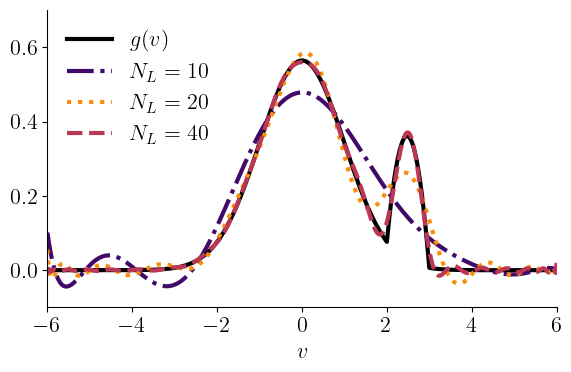

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(v_, g, label=r"$g(v)$", color=color1, linewidth=3)
ax.plot(v_, sol_10, color=color2, ls="-.", label=r"$N_{L} = 10$", linewidth=3)
ax.plot(v_, sol_20, color=color4, ls=":", label=r"$N_{L} = 20$", linewidth=3)
ax.plot(v_, sol_40, color=color3, ls="--", label=r"$N_{L} = 40$", linewidth=3)

legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=16, loc='upper left')
legend.get_frame().set_alpha(0)
ax.set_xlim(-6, 6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$v$")
ax.set_ylim(-0.1, 0.7)
plt.tight_layout()
plt.savefig("../../figures/functional_analysis/legendre_approx.png", dpi=300) 

In [17]:
v_a1 = 1
v_b1 = 4
idx1 = np.argmin(np.abs(v_-v_a1))
idx2 = np.argmin(np.abs(v_-v_b1))

In [18]:
v_[idx1]

1.0

In [19]:
v_[idx2]

4.0

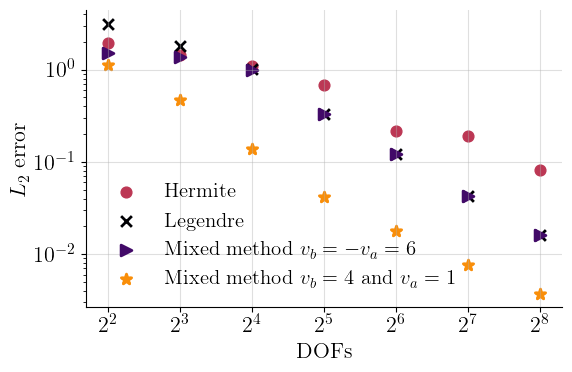

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
Nv_vec = 2**np.arange(2, 9)

for Nv in Nv_vec:
    B = np.zeros(Nv) 
    M1 = np.zeros(Nv) 
    M2 = np.zeros(Nv) 
    C = np.zeros(Nv) 
    sol_legendre = np.zeros(len(v_))
    sol_hermite = np.zeros(len(v_))
    sol_mm1 = aw_psi_hermite(n=0, alpha_s=alpha, u_s=u, v=v_)
    sol_mm2 = aw_psi_hermite(n=0, alpha_s=alpha, u_s=u, v=v_)
    
    for ii in range(Nv):
        B[ii] = scipy.integrate.trapezoid(g*xi_legendre(n=ii, v_a=v_a, v_b=v_b, v=v_), x=v_, dx=np.abs(v_[1] - v_[0])) /(v_b-v_a)
        sol_legendre += B[ii] * xi_legendre(n=ii, v_a=v_a, v_b=v_b , v=v_)
        
        C[ii] = scipy.integrate.trapezoid(g*aw_psi_hermite_complement(n=ii, alpha_s=alpha, u_s=u, v=v_), x=v_, dx=np.abs(v_[1] - v_[0])) /alpha
        sol_hermite += C[ii] * aw_psi_hermite(n=ii, alpha_s=alpha, u_s=u, v=v_)

        M1[ii] = scipy.integrate.trapezoid((g-aw_psi_hermite(n=0, alpha_s=alpha, u_s=u, v=v_))*xi_legendre(n=ii, v_a=v_a, v_b=v_b, v=v_), x=v_, dx=np.abs(v_[1] - v_[0])) /(v_b-v_a)
        sol_mm1 += M1[ii] * xi_legendre(n=ii, v_a=v_a, v_b=v_b , v=v_)

        
        M2[ii] = scipy.integrate.trapezoid(((g-aw_psi_hermite(n=0, alpha_s=alpha, u_s=u, v=v_))[idx1:idx2])*xi_legendre(n=ii, v_a=v_a1, v_b=v_b1, v=v_[idx1:idx2]), x=v_[idx1:idx2], dx=np.abs(v_[1] - v_[0])) /(v_b1 - v_a1)
        basis = np.zeros(len(v_))
        basis[idx1:idx2] = xi_legendre(n=ii, v_a=v_a1, v_b=v_b1 , v=v_[idx1:idx2])
        sol_mm2 += M2[ii] * basis
        
    ax.scatter(Nv, np.linalg.norm(g - sol_hermite, ord=2), color=color3, s=60)
    ax.scatter(Nv, np.linalg.norm(g - sol_legendre, ord=2), color=color1, marker="x", s=60, linewidth=2)
    ax.scatter(Nv, np.linalg.norm(g - sol_mm1, ord=2), color=color2, marker=">", s=60, linewidth=2)
    ax.scatter(Nv, np.linalg.norm(g - sol_mm2, ord=2), color=color4, marker="*", s=60, linewidth=2)

ax.scatter(np.nan, np.nan, color=color3, label="Hermite", s=60)
ax.scatter(np.nan, np.nan, color=color1, marker="x", label="Legendre", s=60, linewidth=2)
ax.scatter(np.nan, np.nan, color=color2, marker=">", label="Mixed method $v_b = -v_a = 6$", s=60, linewidth=2)
ax.scatter(np.nan, np.nan, color=color4, marker="*", label="Mixed method $v_b =4$ and $v_{a} = 1$", s=60, linewidth=2)

ax.set_yscale("log")
ax.set_xscale("log", base=2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=15, loc='lower left')
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.4)
ax.set_xlabel("DOFs")
ax.set_ylabel("$L_{2}$ error")
plt.tight_layout()
plt.savefig("../../figures/functional_analysis/convergence_rate.png", dpi=300) 